In [1]:
#pip install lime

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import nltk
from nltk.corpus import stopwords

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix,f1_score

## 1 - Dataset




<div class="alert alert-block alert-warning">
    We will use the <code>half-moons</code> dataset, which you already know how to handle, to enable result visualization, and the <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)">UCI ML Breast Cancer Wisconsin (Diagnostic)</a> dataset, which has more attributes.
</div>


In [4]:
breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

feature_names = breast_cancer.feature_names
target_names = breast_cancer.target_names

## 2 - Linear Model Training

<div class="alert alert-block alert-warning">
We will learn the classification task using a logistic regression model.
</div>

In [11]:
logreg = LogisticRegression(C=1.0, penalty='l2', solver='liblinear')
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

conf_matrix = confusion_matrix(y_test,y_pred)
conf_matrix

array([[53,  3],
       [ 3, 84]])

- Accuracy: (TP + TN) / (TP + TN + FP + FN)
- Precision: TP / (TP + FP)
- Recall (or Sensitivity): TP / (TP + FN)
- F1-Score: 2 * (Precision * Recall) / (Precision + Recall)

In [11]:
f1_score(y_test, y_pred, average='binary')

0.9726775956284154

<AxesSubplot:title={'center':'Feature importance'}>

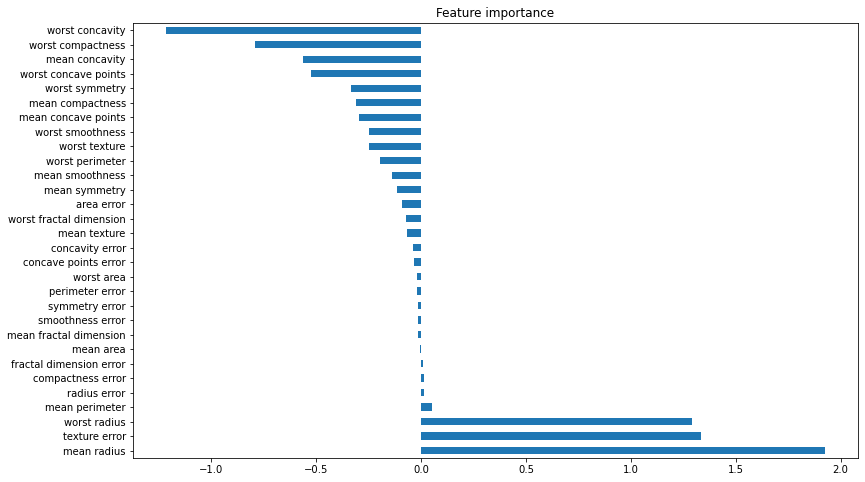

In [12]:
import pandas as pd
coefs = logreg.coef_[0]
plt.figure(figsize=(13,8))
plt.title("Feature importance")
pd.Series(coefs, index=feature_names).nlargest(coefs.size).plot(kind='barh')

#### For testset

<AxesSubplot:title={'center':'Feature importance'}>

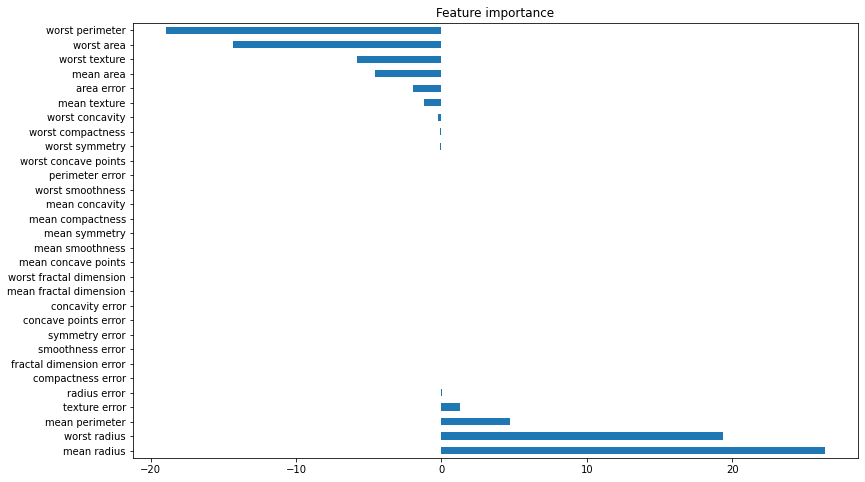

In [13]:
importances_test_example = X_test[0] * coefs
# importances_test_example_normalized = importances_test_example / importances_test_example.sum()
plt.figure(figsize=(13,8))
plt.title("Feature importance")
pd.Series(importances_test_example, index=feature_names).nlargest(importances_test_example.size).plot(kind='barh')

## 3 - Explication avec LIME

<div class="alert alert-block alert-warning">
Nous allons étudier une explication donnée par LIME.
</div>

<div class = "alert alert-block alert-info">
    Q3.1 - Exécuter le bloc ci-dessous pour obtenir une explication sur le premier exemple de la base de test. Commentez.
</div>

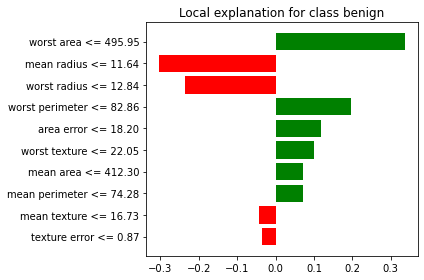

In [14]:
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_test,
    feature_names=feature_names,
    class_names=target_names,
    categorical_features=[],
    mode='classification')

exp = explainer.explain_instance(X_test[0], logreg.predict_proba, num_features=10)

exp.as_pyplot_figure()
plt.tight_layout()

Pour classifier l'exemple 0 de la base de test en tant que classe 'benign' en se basant sur les explications de LIME:

- Pour prédire l'exemple 0 en tant que classe 'benign', l'attribut 'worst_area' avec des valeurs inférieures à 495.95 a un impact positif sur cette prédiction. Cela signifie que lorsque la valeur de 'worst_area' est faible, il est plus probable que l'exemple soit classé comme 'benign'. En d'autres termes, les tumeurs avec une valeur 'worst_area' inférieure sont plus susceptibles d'être bénignes.

- En revanche, l'attribut 'mean_radius' avec une valeur inférieure à 11.64 a un impact négatif sur la prédiction de la classe 'benign'. Cela signifie que lorsque la valeur de 'mean_radius' est faible, cela renforce la prédiction que l'exemple n'est pas 'benign' (c'est-à-dire maligne).

- Les attributs 'worst_area', 'worst_perimeter', 'area_error', 'worst_texture', 'mean_area', et 'mean_perimeter' ont un rôle positif dans la prédiction de la classe 'benign'. Leurs valeurs inférieures contribuent à renforcer la prédiction de 'benign'. Cela indique que lorsque ces caractéristiques ont des valeurs faibles, le modèle est plus enclin à prédire 'benign'.

- D'un autre côté, les attributs 'mean_radius', 'worst_radius', 'mean_texture' et 'texture_error' ont un impact négatif sur la prédiction de la classe 'benign'. Leurs valeurs élevées renforcent la prédiction négative de 'benign'. En d'autres termes, lorsque ces caractéristiques ont des valeurs élevées, le modèle est plus susceptible de prédire une classe autre que 'benign'.

<div class = "alert alert-block alert-info">
    Q3.2 - Comparer avec l'exemple suivant de la base de test.
</div>

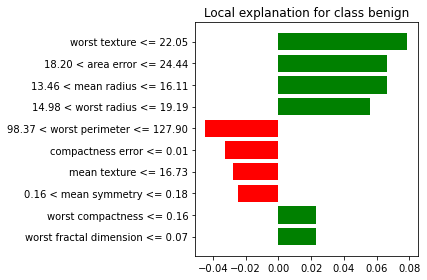

In [15]:
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_test,
    feature_names=feature_names,
    class_names=target_names,
    categorical_features=[],
    mode='classification')

exp = explainer.explain_instance(X_test[1], logreg.predict_proba, num_features=10)

exp.as_pyplot_figure()
plt.tight_layout()

## 4 - Expérimentations

<div class="alert alert-block alert-info">
    Faire des tests pour examiner le comportement de LIME, par exemple pour examiner sa stabilité par rapport à la donné d'intérêt ou par rapport au classifieur, selon un protocole que vous définirez après avoir spécifié l'étude que vous souhaitez mener.
</div>

### 4.1 - Stabilité

Pour pouvoir etudier la stabilité de l'algorithme LIME , on va se concentrer sur deux aspects : 
- La stabilité au niveau des features renvoyés.
- la stabilité au niveau des valeurs renvoyés pour une feature donnée.

In [73]:
sample = 14
nb_iter = 30
num_features = 10

feat_names = {}
dico_values = {}

for _ in tqdm(range(nb_iter)):

    explainer = LimeTabularExplainer(X_test,
        feature_names=feature_names,
        class_names=target_names,
        categorical_features=[],
        mode='classification')

    exp = explainer.explain_instance(X_test[sample], logreg.predict_proba, num_features=num_features)
    
    names = np.array(exp.as_list())[:,0]
    values = np.array(exp.as_list())[:,1]
    values = values.astype(float).tolist()
    
    for i_feat , name in enumerate(names):
        if name in feat_names.keys():
            feat_names[name] += 1
        else:
            feat_names[name] = 1
        if name in dico_values.keys():
            dico_values[name].append(values[i_feat])
        else: dico_values[name] = [values[i_feat]]

100%|███████████████████████████████████████████| 30/30 [06:11<00:00, 12.39s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

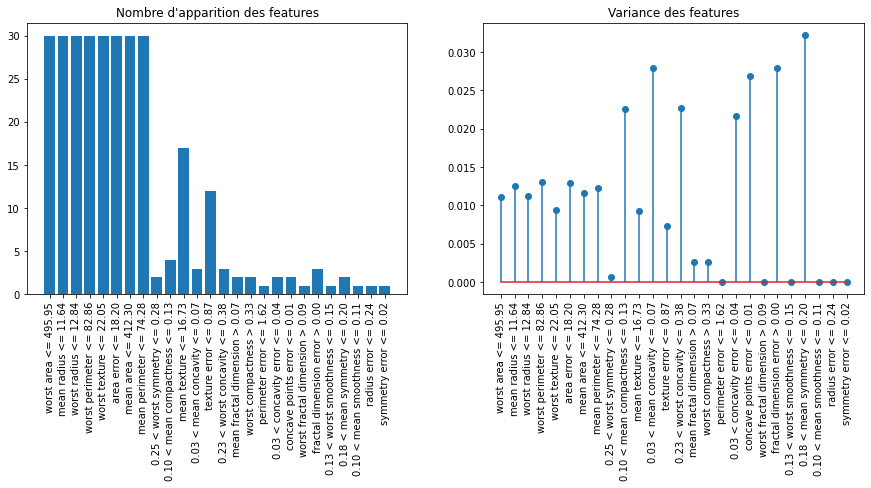

In [87]:
names = list(feat_names.keys())
counts = list(feat_names.values())

variances = []
for name in dico_values.keys():
    variances.append(np.std(dico_values[name]))
    
    
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.bar(names,counts)
plt.title("Nombre d'apparition des features")
plt.xticks(rotation=90)

plt.subplot(122)
plt.stem(names,variances)
plt.title("Variance des features")
plt.xticks(rotation=90)
plt.show

### 4.2 - Étude de la stabilité des prédictions

En utilisant l'explication fournie par LIME, nous tentons de vérifier la validité de cette explication en modifiant l'attribut identifié comme le plus significatif par LIME. Si cette modification entraîne un changement de la classe prédite, cela suggère que l'explication de LIME est cohérente et précise dans sa mise en évidence de l'importance de cet attribut. En d'autres termes, l'explication de LIME est validée si la modification de l'attribut clé influence réellement la prédiction du modèle.

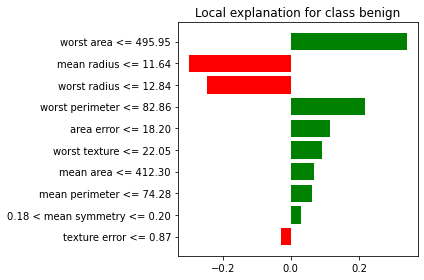

Tentative de changement de classe en changeant l'attribut 'mean raduis' 
Exemple original :  [1]
Exemple apres changement de l'attribut :  [0]


In [142]:
sample = 14
exp = explainer.explain_instance(X_test[sample], logreg.predict_proba, num_features=num_features)
exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

print("Tentative de changement de classe en changeant l'attribut 'mean raduis' ")
sample_copy = copy.deepcopy(X_test[sample])

feat_indice2 = np.where(feature_names == 'mean radius')[0][0]

sample_copy[feat_indice2] = -X_test[sample][feat_indice2]

print("Exemple original : ",logreg.predict([X_test[sample]]))
print("Exemple apres changement de l'attribut : ",logreg.predict([sample_copy]))

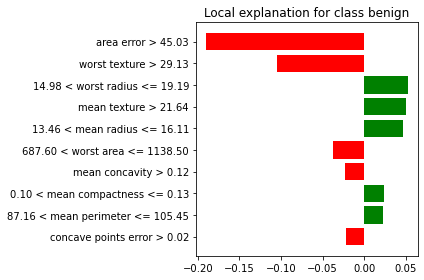

Tentative de changement de classe en changeant l'attribut 'mean raduis' 
Exemple original :  [0]
Exemple apres changement de l'attribut :  [1]


In [146]:
sample = 96
exp = explainer.explain_instance(X_test[sample], logreg.predict_proba, num_features=num_features)
exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

print("Tentative de changement de classe en changeant l'attribut 'mean raduis' ")
sample_copy = copy.deepcopy(X_test[sample])

feat_indice2 = np.where(feature_names == 'area error')[0][0]

sample_copy[feat_indice2] = -X_test[sample][feat_indice2]

print("Exemple original : ",logreg.predict([X_test[sample]]))
print("Exemple apres changement de l'attribut : ",logreg.predict([sample_copy]))

### 4.3 - Comparaison de modèles

In [154]:
def give_explications(model,data,feature_names,target_names,sample):
    
    explainer = LimeTabularExplainer(data,
    feature_names=feature_names,
    class_names=target_names,
    categorical_features=[],
    mode='classification')

    exp = explainer.explain_instance(data[sample], model.predict_proba, num_features=10)
    
    return exp 

In [159]:
# fitting 
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

svm = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm.fit(X_train,y_train)

# explications
exp_logreg = give_explications(logreg,X_test,feature_names,target_names,96)
exp_mlp = give_explications(mlp,X_test,feature_names,target_names,96)
exp_svm = give_explications(svm,X_test,feature_names,target_names,96)

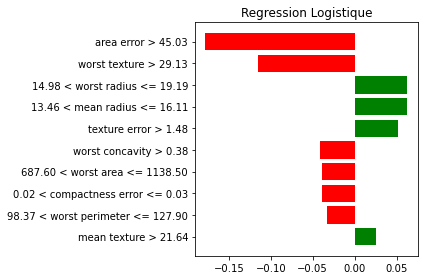

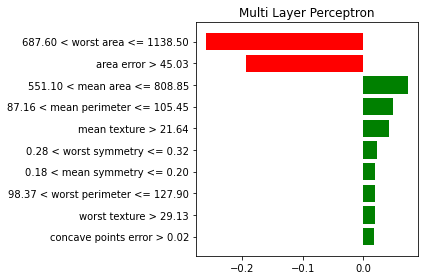

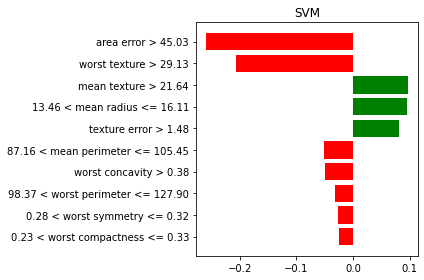

In [166]:

exp_logreg.as_pyplot_figure()
plt.title("Regression Logistique")
plt.tight_layout()
plt.show()

exp_mlp.as_pyplot_figure()
plt.title("Multi Layer Perceptron")
plt.tight_layout()
plt.show()

exp_svm.as_pyplot_figure()
plt.title("SVM")
plt.tight_layout()
plt.show()

In [191]:
names_logreg = np.array(exp_logreg.as_list())[:,0]
names_mlp = np.array(exp_mlp.as_list())[:,0]
names_svm = np.array(exp_svm.as_list())[:,0]

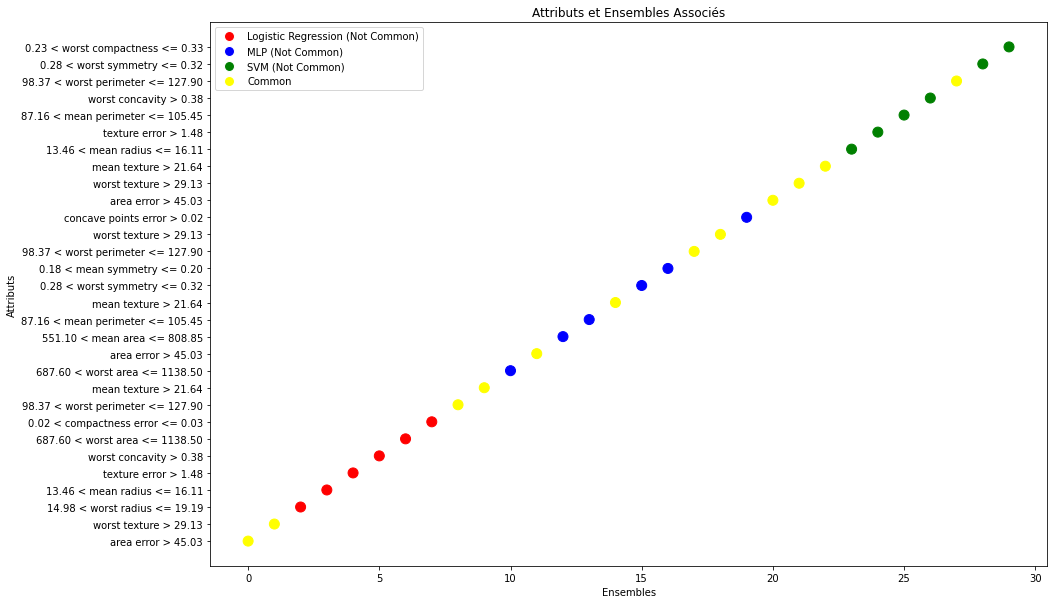

In [198]:
import matplotlib.pyplot as plt

# Créer des listes pour stocker les attributs, les ensembles auxquels ils appartiennent et s'ils sont communs
attributes = []
sets = []
common = []

# Associer chaque attribut à son ensemble et déterminer s'ils sont communs
for name in names_logreg:
    attributes.append(name)
    sets.append("Logistic Regression")
    if name in names_mlp and name in names_svm:
        common.append("Common")
    else:
        common.append("Not Common")

for name in names_mlp:
    attributes.append(name)
    sets.append("MLP")
    if name in names_logreg and name in names_svm:
        common.append("Common")
    else:
        common.append("Not Common")

for name in names_svm:
    attributes.append(name)
    sets.append("SVM")
    if name in names_logreg and name in names_mlp:
        common.append("Common")
    else:
        common.append("Not Common")

# Créer une couleur pour chaque ensemble
colors = {'Logistic Regression': 'red', 'MLP': 'blue', 'SVM': 'green'}

# Créer une couleur pour les attributs communs
common_color = 'yellow'

# Créer une liste de couleurs en fonction de la condition de communs
point_colors = [common_color if status == "Common" else colors[set_name] for set_name, status in zip(sets, common)]

# Tracer les points
plt.figure(figsize=(15, 10))
plt.scatter(range(len(attributes)), range(len(attributes)), c=point_colors, marker='o', s=100)

# Étiqueter les axes
plt.yticks(range(len(attributes)), attributes)
plt.ylabel('Attributs')
plt.xlabel('Ensembles')

# Créer une légende
legend_elements = []
for set_name, color in colors.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f'{set_name} (Not Common)', markerfacecolor=color, markersize=10))
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Common', markerfacecolor=common_color, markersize=10))
plt.legend(handles=legend_elements)

# Afficher le nuage de points
plt.title("Attributs et Ensembles Associés")
plt.show()


Il est à noter que la plupart des attributs renvoyés sont partagés par les trois modèles, même si chaque modèle génère également des attributs uniques. Cette observation suggère que nous pouvons exploiter cette convergence en agrégeant les résultats des trois modèles pour obtenir une explication plus complète et fiable pour l'utilisateur. Cette approche devient particulièrement utile lorsque des incertitudes subsistent quant à une explication, car le deuxième ou le troisième modèle peut venir confirmer ou réfuter l'explication du modèle de base, renforçant ainsi la confiance dans l'interprétation des résultats.

## 5 - Données textuelles

<div class="alert alert-block alert-warning">
    Nous allons apprendre un modèle de classification random forest sur les données <code>fetch_20newsgroups</code> puis utiliser LIME pour obtenir des explications sur la classification d'exemples.
</div>

<div class = "alert alert-block alert-info">
À l'aide de la <a href="https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py">documentation du dataset fetch_20newsgroups</a>,  apprendre un modèle random forest de classification bi-classe de texte.
</div>

In [312]:
from time import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

newsgroups_data = fetch_20newsgroups(subset='all', categories=['alt.atheism', 'sci.space'])
data = newsgroups_data.data
target = newsgroups_data.target

In [404]:
categories = [
    "rec.sport.baseball",
    "sci.space"
]


def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


def load_dataset(verbose=False, remove=()):
    """Load and vectorize the 20 newsgroups dataset."""

    data_train = fetch_20newsgroups(
        subset="train",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    data_test = fetch_20newsgroups(
        subset="test",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    # order of labels in `target_names` can be different from `categories`
    target_names = data_train.target_names

    # split target in a training set and a test set
    y_train, y_test = data_train.target, data_test.target

    # Extracting features from the training data using a sparse vectorizer
    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    X_train = vectorizer.fit_transform(data_train.data)
    duration_train = time() - t0

    # Extracting features from the test data using the same vectorizer
    t0 = time()
    X_test = vectorizer.transform(data_test.data)
    duration_test = time() - t0

    feature_names = vectorizer.get_feature_names()

    if verbose:
        # compute size of loaded data
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)

        print(
            f"{len(data_train.data)} documents - "
            f"{data_train_size_mb:.2f}MB (training set)"
        )
        print(f"{len(data_test.data)} documents - {data_test_size_mb:.2f}MB (test set)")
        print(f"{len(target_names)} categories")
        print(
            f"vectorize training done in {duration_train:.3f}s "
            f"at {data_train_size_mb / duration_train:.3f}MB/s"
        )
        print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")
        print(
            f"vectorize testing done in {duration_test:.3f}s "
            f"at {data_test_size_mb / duration_test:.3f}MB/s"
        )
        print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return vectorizer,data_train['data'], data_test['data'] , X_train, X_test, y_train, y_test, feature_names, target_names

<div class = "alert alert-block alert-info">
Utilisez LIME pour obtenir des explications sur les prédictions obtenues sur des exemples.
    </div>

In [405]:
vecto,data_train,data_test,X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(verbose=True)

1190 documents - 2.04MB (training set)
791 documents - 1.34MB (test set)
2 categories
vectorize training done in 0.201s at 10.167MB/s
n_samples: 1190, n_features: 5214
vectorize testing done in 0.131s at 10.180MB/s
n_samples: 791, n_features: 5214


In [406]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

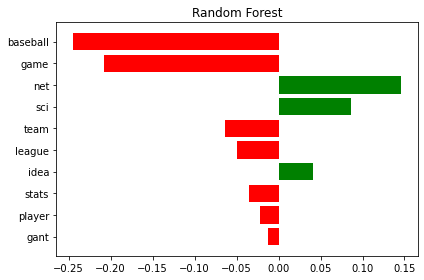

In [407]:
exp_rf_96 = give_explications(rf_classifier,X_test,feature_names,target_names,sample=96)

exp_rf_96.as_pyplot_figure()
plt.title("Random Forest")
plt.tight_layout()
plt.show()

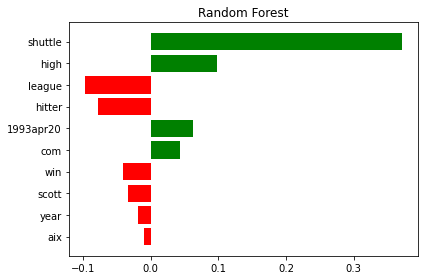

In [408]:
exp_rf_1 = give_explications(rf_classifier,X_test,feature_names,target_names,sample=1)

exp_rf_1.as_pyplot_figure()
plt.title("Random Forest")
plt.tight_layout()
plt.show()

L'analyse de l'explication fournie par LIME pour l'exemple 96 révèle que pour prédire correctement la classe d'appartenance, certains mots-clés tels que 'net', 'sci', et 'idea' sont les plus déterminants. Ces termes sont fortement associés au domaine de l'espace. En revanche, les caractéristiques moins pertinentes, mais cruciales pour prédire la classe opposée, sont directement liées au vocabulaire du sport et du baseball, notamment 'baseball', 'game', 'team', et 'league'.

## 6 - Implémentation de LIME

<div class="alert alert-block alert-info">
    Sur des données textuelles, implémentez une version rudimentaire de LIME en utilisant la fonction de proximité proposée dans le cours. Retrouvez-vous les mêmes vecteurs d'importance qu'avec la bibliothèque LIME ?
</div>

In [519]:
ind_sample = 96
sample = data_test[ind_sample]
predicted_label = rf_classifier.predict(X_test[ind_sample])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform([sample])
feature_names = np.array(vectorizer.get_feature_names())

# supprimer les tokens de type 'int'
feature_names = feature_names[66:]

In [587]:
b = np.array([word for word in feature_names if word.lower() not in stopwords.words('english')])
len(b)

190

In [591]:
vecto

TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english', sublinear_tf=True)

In [613]:
def LIME_DIY(ind_sample,sample,predicted_label,vecto,range_disabling=np.arange(50,150),nb_data=100,with_stop_words=True):
    
    copy_sample = copy.deepcopy(sample)
    
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform([sample])
    feature_names = np.array(vectorizer.get_feature_names())
    # supprimer les tokens de type 'int'
    feature_names = feature_names[66:]

    if with_stop_words == False:
        feature_names = np.array([word for word in feature_names if word.lower() not in stopwords.words('english')])

        
    data_perturbed = []
    weights = []
    N = len(feature_names)
    probas_f = []
    
    for _ in range(nb_data_perturbed):
    
        # choisis le nombre de mots à desctiver
        words_to_disable = np.random.choice((range_disabling),1,replace=False)

        # choisir les mots à desactiver
        indices = np.random.choice(len(feature_names), words_to_disable, replace=False)
        perturbed_sample = np.ones((len(feature_names)))
        perturbed_sample[indices] = 0

        # construction des données bruitées
        data_perturbed.append(perturbed_sample)

        # construction du vecteur de poids 
        weights.append(float(words_to_disable / N))

        # Liste de mots à supprimer
        mots_a_supprimer = feature_names[indices]

        # Divisez le paragraphe en mots en utilisant l'espace comme séparateur
        mots_copy_sample = copy_sample.split()

        # Parcourez les mots et conservez uniquement ceux qui ne sont pas dans la liste de mots à supprimer
        mots_restants = [mot for mot in mots_copy_sample if mot.lower() not in mots_a_supprimer]

        # Rejoignez les mots restants pour former un nouveau paragraphe
        copy_sample2 = ' '.join(mots_restants)
        copy_sample2_vect = vecto.transform([copy_sample2])
        probas = np.array(rf_classifier.predict_proba(copy_sample2_vect)[0])

        probas_f.append(probas[predicted_label][0])
    
    
    return np.array(data_perturbed) , np.array(weights) , np.array(probas_f)

def display_importances(importances1,words1,importances2,words2):

    # Créez une figure
    plt.figure(figsize=(13,5))

    plt.subplot(121)
    # Créez un diagramme à barres pour les importances
    plt.barh(words1, importances1, color='green')

    # Ajoutez des étiquettes et un titre
    plt.xlabel('Importance')
    plt.title('Importance des mots (LIME DIY)')

    # Affichez la figure
    plt.tight_layout()
    
    plt.subplot(122)
    
    plt.barh(words2, importances2, color='red')

    # Ajoutez des étiquettes et un titre
    plt.xlabel('Importance')
    plt.title('Importance des mots (LIME DIY)')

    # Affichez la figure
    plt.tight_layout()
    
    plt.show()


#### version avec stop words

In [599]:
range_disabling = np.arange(50,100)
nb_data=300

data_perturbed , weights , probas_f = LIME_DIY(ind_sample,
                                              sample,predicted_label,
                                              vecto,range_disabling=range_disabling,nb_data=nb_data,
                                               with_stop_words=True)

In [600]:
reglin = LinearRegression()
reglin.fit(data_perturbed,probas_f)

predictions = reglin.predict(data_perturbed)

mse = mean_squared_error(probas_f, predictions)
r2 = r2_score(probas_f, predictions)

print("Mean Squared Error:", mse)
print("R-squared (R²):", r2)

Mean Squared Error: 1.9530855566030958e-32
R-squared (R²): 1.0


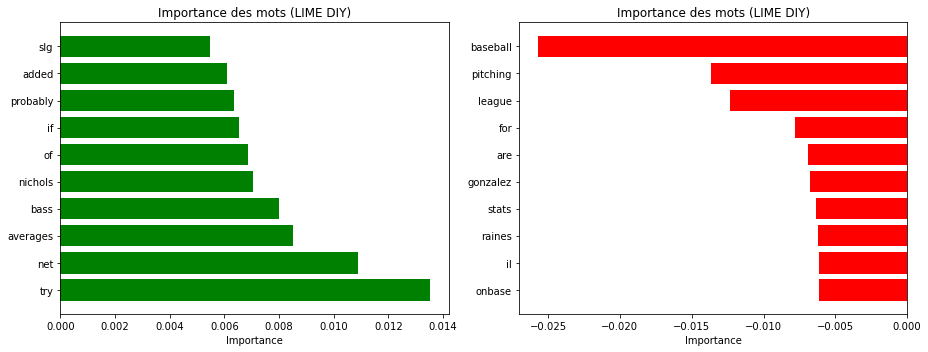

In [614]:
coefs = reglin.coef_
nb_features = 10

# Utilisez enumerate pour obtenir à la fois les éléments et leurs indices
enumerated_coefs = list(enumerate(coefs))

# Trier la liste en fonction des éléments (en ordre décroissant)
sorted_coefs = sorted(enumerated_coefs, key=lambda x: x[1], reverse=True)

# Prendre les 10 premiers éléments (les 10 plus grandes valeurs) avec leurs indices
most_importante = sorted_coefs[:nb_features]

# Extraire uniquement les valeurs (éléments) et les indices
valeurs_most = [valeur for index, valeur in most_importante]
indices_most = [index for index, valeur in most_importante]

less_importante = sorted_coefs[-nb_features:]

valeurs_less = [valeur for index, valeur in less_importante]
indices_less = [index for index, valeur in less_importante]

display_importances(valeurs_most , feature_names[indices_most],valeurs_less , feature_names[indices_less])

#### version sans stop words

In [615]:
range_disabling = np.arange(50,100)
nb_data=300

data_perturbed , weights , probas_f = LIME_DIY(ind_sample,
                                              sample,predicted_label,
                                              vecto,range_disabling=range_disabling,nb_data=nb_data,
                                               with_stop_words=False)

reglin = LinearRegression()
reglin.fit(data_perturbed,probas_f)

predictions = reglin.predict(data_perturbed)

mse = mean_squared_error(probas_f, predictions)
r2 = r2_score(probas_f, predictions)

print("Mean Squared Error:", mse)
print("R-squared (R²):", r2)

Mean Squared Error: 1.1309060633441849e-32
R-squared (R²): 1.0


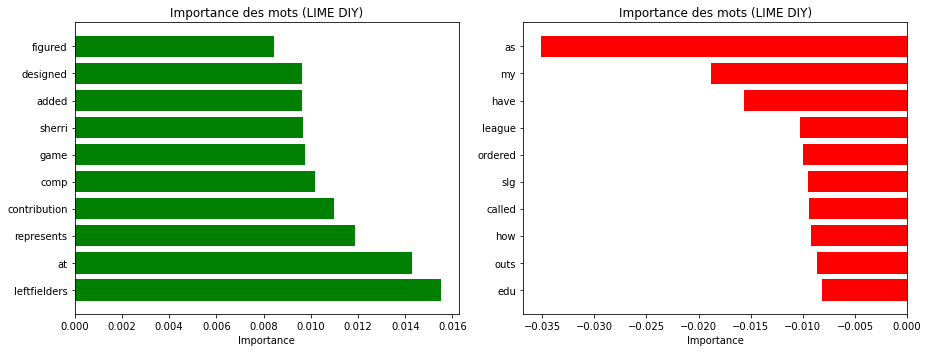

In [616]:
coefs = reglin.coef_
nb_features = 10

# Utilisez enumerate pour obtenir à la fois les éléments et leurs indices
enumerated_coefs = list(enumerate(coefs))

# Trier la liste en fonction des éléments (en ordre décroissant)
sorted_coefs = sorted(enumerated_coefs, key=lambda x: x[1], reverse=True)

# Prendre les 10 premiers éléments (les 10 plus grandes valeurs) avec leurs indices
most_importante = sorted_coefs[:nb_features]

# Extraire uniquement les valeurs (éléments) et les indices
valeurs_most = [valeur for index, valeur in most_importante]
indices_most = [index for index, valeur in most_importante]

less_importante = sorted_coefs[-nb_features:]

valeurs_less = [valeur for index, valeur in less_importante]
indices_less = [index for index, valeur in less_importante]

display_importances(valeurs_most , feature_names[indices_most],valeurs_less , feature_names[indices_less])

L'approche de simplification de LIME_DIY peut présenter des avantages pédagogiques et conceptuels, mais elle se heurte à des limitations de performance et de scalabilité par rapport à la version complète de LIME. La version DIY simplifiée peut être adaptée pour des cas d'utilisation spécifiques et des démonstrations conceptuelles, mais elle n'est pas aussi robuste que la version complète de LIME, qui a été développée pour gérer une plus grande variété de scénarios.

La préparation des données avant la génération des exemples perturbés, telle que la sélection de tokens (suppression de stop words, stemming, etc.), peut améliorer la qualité des explications. En effet, réduire la dimensionnalité de l'espace des caractéristiques en éliminant des mots ou des tokens inutiles peut aider à obtenir des explications plus significatives et à réduire le bruit.

De plus, la mesure de proximité utilisée pour choisir les exemples perturbés est en effet un élément clé de LIME.La mesure de proximité utilisé pour LIME_DIY presente des limites : certe son implementation est facile mais elle represente pas une reelle proximité surtout en grande dimension. 

En résumé, LIME_DIY peut être une excellente ressource pour comprendre les concepts sous-jacents à LIME, mais pour des cas d'utilisation réels et des applications de haute performance, la version complète de LIME avec des des eventuelles améliorations telles que la préparation de données est souvent nécessaire.